<a href="https://colab.research.google.com/github/ralfcam/MT_field_adq/blob/master/UB_LEMIs_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Facultad de Ciencias de la Tierra](https://www.ub.edu/portal/documents/5259153/0/ciencies+de+la+terra_pos_1tinta.png/7a974a91-28c9-2b2a-8f57-0d0d7bd3f358?t=1529322299082)](https://www.ub.edu/portal/web/ciencias-tierra)

# [Departament de Geodinàmica i Geofísica](http://www.ub.edu/geodgf)


---


### **Broadband magnetotellurics Proccessing** with ***MTpy***


---



[**Stations Description**. Sheet](https://drive.google.com/file/d/1ydjyuMJXt6BxJAXVVdCf0Kye3yfoEJEs/view?usp=sharing)

### Imports


In [0]:
import os
from datetime import datetime
from glob import glob

from pandas import read_csv, to_datetime
%load_ext google.colab.data_table

import matplotlib.pyplot as plt  # Display figures inline in Jupyter notebook

import seaborn as sns # Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(30, 4)})

## Connect to drive (or access raw .t files from datalogger) 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Set Global Variables

In [0]:
STATION_NAME = '20-Z-1'   # EDITABLE  	
SAMPLING_RATE = 1  # EDITABLE, data logger frequency sammple in Hz

START_DATE = '2020-01-24 12:00:00.00'  # EDITABLE, format %Y-%m-%d %H:%M:%S.%f

STATION_ID = 89	  # EDITABLE

STATION_LAT =	42.29313 # EDITABLE
STATION_LON =	0.93841  # EDITABLE

LEN_EX = 78.8		  # EDITABLE
LEN_EY = 69.8     # EDITABLE

In [0]:
CURRENT_PATH = os.getcwd()
DRIVE_PATH = 'drive/My Drive/st_zips'
DRIVE_OUT_PATH = 'drive/My Drive/st_deliver/{}'.format(STATION_NAME)

BIRRP_OUT_DIR = os.path.join(CURRENT_PATH, '/mt_birrp_out') 

os.environ['STATION_NAME'] = STATION_NAME

STATION_DIR = os.path.join(CURRENT_PATH, STATION_NAME)
os.environ['STATION_DIR'] = STATION_DIR

DRIVE_DIR = os.path.join(CURRENT_PATH, DRIVE_PATH)
os.environ['DRIVE_DIR'] = DRIVE_DIR

OUTPUT_PATH = os.path.join(CURRENT_PATH, '/out')

if not os.path.exists(STATION_DIR):
  os.mkdir(STATION_DIR)

if not os.path.exists(OUTPUT_PATH):
  os.mkdir(OUTPUT_PATH)

if not os.path.exists(DRIVE_OUT_PATH):
  os.mkdir(DRIVE_OUT_PATH)

if not os.path.exists(BIRRP_OUT_DIR):
  os.mkdir(BIRRP_OUT_DIR)
  os.mkdir('{}/{}'.format(BIRRP_OUT_DIR, STATION_NAME))

## Read to Dataframe, view data and analyse

In [0]:
!unzip '{DRIVE_DIR}/{STATION_NAME}.zip' -d '{STATION_DIR}'

Archive:  /content/drive/My Drive/st_zips/20-Z-1.zip
  inflating: /content/20-Z-1/190705092300.t89  
  inflating: /content/20-Z-1/191015174600.t89  
  inflating: /content/20-Z-1/191016000008.t89  
  inflating: /content/20-Z-1/191017000008.t89  
  inflating: /content/20-Z-1/191018000008.t89  
  inflating: /content/20-Z-1/191019000008.t89  
  inflating: /content/20-Z-1/191020000008.t89  
  inflating: /content/20-Z-1/191021000008.t89  
  inflating: /content/20-Z-1/191022000008.t89  
  inflating: /content/20-Z-1/191023000008.t89  
  inflating: /content/20-Z-1/191024000008.t89  
  inflating: /content/20-Z-1/191025000008.t89  
  inflating: /content/20-Z-1/191026000008.t89  
  inflating: /content/20-Z-1/191027000008.t89  
  inflating: /content/20-Z-1/191028000008.t89  
  inflating: /content/20-Z-1/191029000008.t89  
  inflating: /content/20-Z-1/191030000008.t89  
  inflating: /content/20-Z-1/191031000008.t89  
  inflating: /content/20-Z-1/191101000008.t89  
  inflating: /content/20-Z-1/191103

In [0]:
!cat '{STATION_DIR}'/*.t* > '{STATION_DIR}/{STATION_NAME}.dat' 
# Concatenation works IF input files are named chronologicaly (Lemis outputs such)

In [0]:
COL_NAMES = ['Any', 'Mes', 'Dia', 'Hora', 'min', 'seg', 'hx',
             'hy', 'hz', 'T ext.', 'T flux', 'ex', 'ey', 'E3',
             'E4', 'Dades per segon']

COL_EXCLUDE = ['T ext.', 'T flux', 'E3', 'E4', 'Dades per segon']

SUBSET = ['ex', 'ey', 'hx', 'hy', 'hz']

station_df = read_csv('{}/{}.dat'.format(STATION_DIR, STATION_NAME),
                      delim_whitespace=True, error_bad_lines=False, 
                      names=COL_NAMES,
                      parse_dates={'date':COL_NAMES[0:6]}, 
                      index_col='date'
                      )

station_df = station_df.drop(columns=COL_EXCLUDE)

# del station_df

### Dipole length correction

In [0]:
station_df['ex'] /= LEN_EX
station_df['ey'] /= LEN_EY

### Polarity correction

In [0]:
# station_df['hx'] *= -1
# station_df['hy'] *= -1

### Describe (statistics) Time Series

In [0]:
WELL_MEASSURED_DAYS = 999
INIT_DAYS = 110 # TIME IN DAYS (NON-INTEGER ALLOWED!) TO REMOVE FROM INIT
station_ss = station_df[int(3600*24*INIT_DAYS):int(3600*24*WELL_MEASSURED_DAYS)]
desc = station_ss.describe()
desc  # or
# station_ss.head(1000)

,hx,hy,hz,ex,ey
count,1.647008e+06,1.647008e+06,1.647008e+06,1.647008e+06,1.647008e+06
mean,2.432177e+04,7.184349e+01,3.869237e+04,2.395471e+01,-2.164685e+01
std,1.222715e+01,1.099918e+01,6.428182e+00,3.857992e+00,3.863715e+00
min,2.424845e+04,1.834000e+01,3.866918e+04,1.540939e+01,-3.472708e+01
25%,2.431673e+04,6.783000e+01,3.869058e+04,2.082697e+01,-2.461680e+01
50%,2.432352e+04,7.320000e+01,3.869343e+04,2.361980e+01,-2.115501e+01
75%,2.432839e+04,7.809000e+01,3.869624e+04,2.659873e+01,-1.888496e+01
max,2.436036e+04,1.226200e+02,3.871581e+04,3.491168e+01,-6.874499e+00


## Plot Time Series
For deeper ploting strategies you may refer to this simple [tutorial](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/)


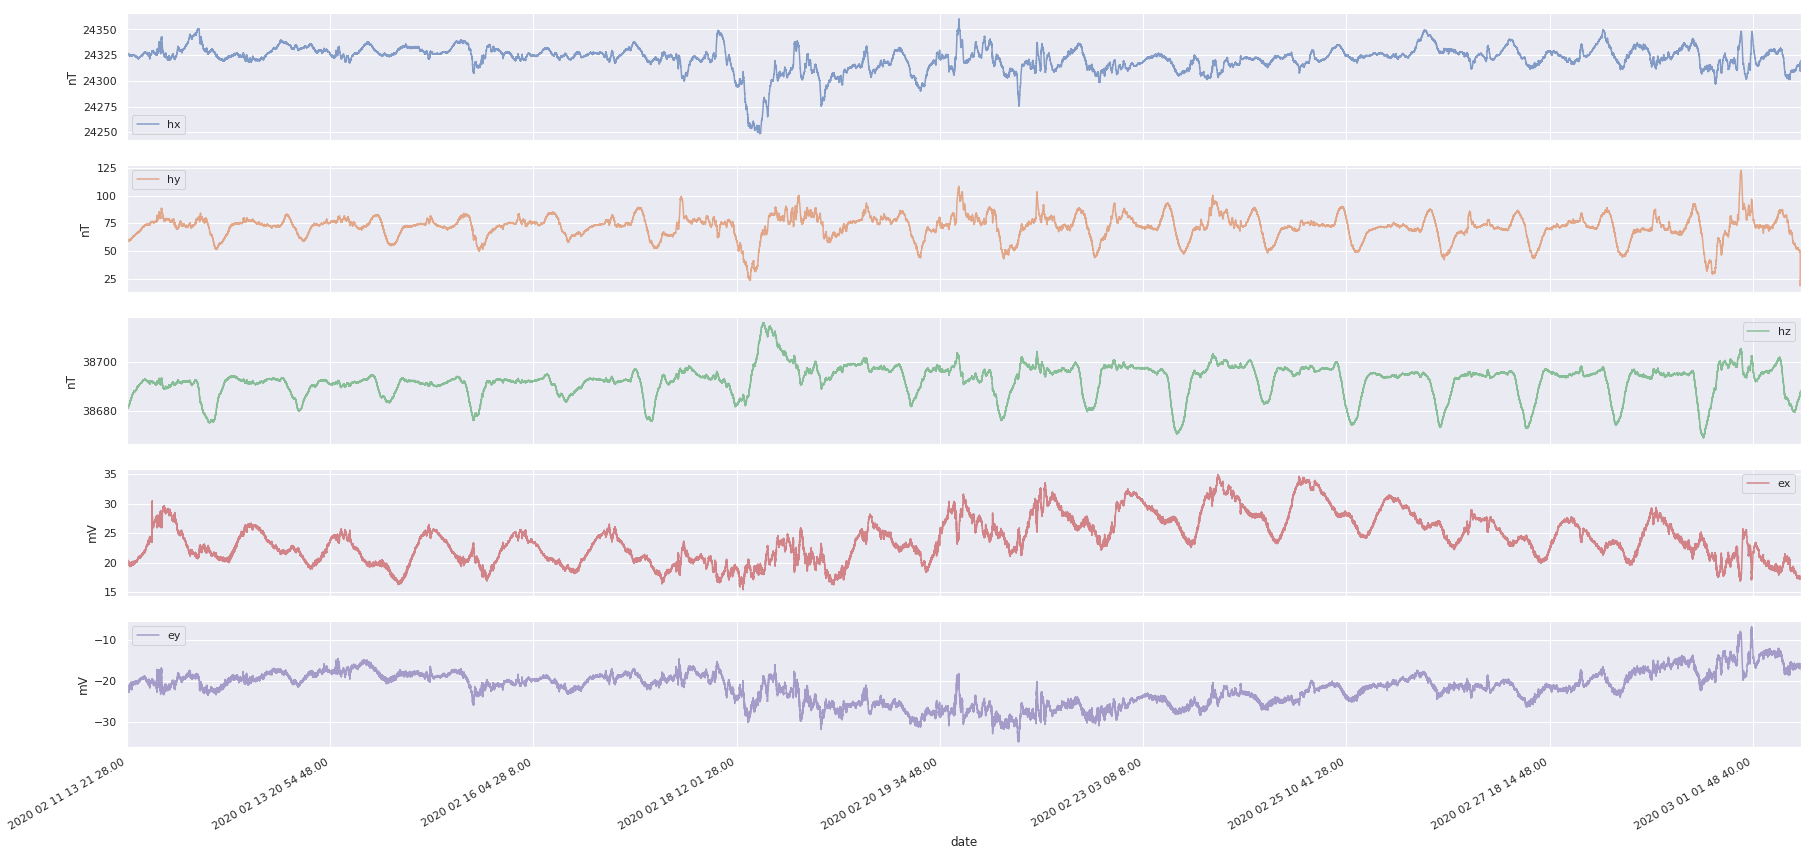

In [0]:
axes = station_ss.plot(alpha=0.66, figsize=(30, 15), subplots=True)
for ax, ss in zip(axes, station_ss.columns):
    y_lalb = 'nT' if 'h' in ss else 'mV'
    ax.set_ylabel(y_lalb)

plt.savefig(DRIVE_OUT_PATH + '/{}_ts_plot'.format(STATION_NAME))

In [0]:
# from scipy import signal

# for component in ['ex', 'ey', 'hx', 'hy', 'hz']:
# station_ss['ey'] = signal.detrend(station_ss['ey'])
# station_ss['ey'] -=  desc['ey'].mean()

In [0]:
# https://towardsdatascience.com/time-series-of-price-anomaly-detection-13586cd5ff46
# from sklearn.svm import OneClassSVM
# to_filter_component = station_ss['ex'].reshape(-1, 1)

# # train oneclassSVM 

# clf = OneClassSVM(gamma='auto').fit(to_filter_component)
# filtered = clf.predict(to_filter_component)

# Start Proccessing

### Install MTpy


Obtain the mtpy source code:
    
git clone https://github.com/MTgeophysics/mtpy

MTpy Documentation
https://mtpy2.readthedocs.io/en/develop/


In [0]:
# !git clone https://github.com/MTgeophysics/mtpy

In [0]:
# # set PYTHONPATH for MTpy
# import sys
# sys.path.insert(0,'/content/mtpy')

Alternatively use pip to install the libary (*not yet supported by the authors*)

In [0]:
%%capture
!pip install MTpy  # Successfully installed MTpy-1.1.3

In [0]:
# import mtpy
# mtpy.__version__  # '1.1.3'

#### MTPy Imports

In [0]:
import numpy as np

# AS December 2019 python-2 runtime is still used to run MTpy
from mtpy.core import mt, ts, jfile
from mtpy.processing import birrp
import mtpy.utils.configfile as mtcfg

### Compile BIRRP

In [0]:
%%capture
!unzip './drive/My Drive/birrp.zip' -d './BIRRP'
!gfortran -o ./BIRRP/birrp.exe ./BIRRP/*.f
!rm -r ./BIRRP/*.f ./BIRRP/*.o

### Create TS Files


    MT time series object that will read/write data in different formats
    including hdf5, txt, miniseed.
    
    The foundations are based on Pandas Python package.
    
    The data are store in the variable ts, which is a pandas dataframe with
    the data in the column 'data'.  This way the data can be indexed as a
    numpy array:
        
        >>> MTTS.ts['data'][0:256]
        
        or
        
        >>> MTTS.ts.data[0:256]
        
    Also, the data can be indexed by time (note needs to be exact time):
        
        >>> MTTS.ts['2017-05-04 12:32:00.0078125':'2017-05-05 12:35:00]
    
    Input ts as a numpy.ndarray or Pandas DataFrame
    ==================== ==================================================
    Metadata              Description        
    ==================== ==================================================
    azimuth              clockwise angle from coordinate system N (deg)
    calibration_fn       file name for calibration data
    component            component name [ 'ex' | 'ey' | 'hx' | 'hy' | 'hz']
    coordinate_system    [ geographic | geomagnetic ]
    datum                datum of geographic location ex. WGS84
    declination          geomagnetic declination (deg)
    dipole_length        length of dipole (m)
    data_logger          data logger type
    instrument_id        ID number of instrument for calibration
    lat                  latitude of station in decimal degrees
    lon                  longitude of station in decimal degrees
    n_samples            number of samples in time series
    sampling_rate        sampling rate in samples/second
    start_time_epoch_sec start time in epoch seconds
    start_time_utc       start time in UTC
    station              station name
    units                units of time series
    ==================== ==================================================
    
    .. note:: Currently only supports hdf5 and text files
    ======================= ===============================================
    Method                  Description        
    ======================= ===============================================
    read_hdf5               read an hdf5 file
    write_hdf5              write an hdf5 file
    write_ascii_file        write an ascii file
    read_ascii_file         read an ascii file
    ======================= ===============================================
        
    
    :Example: :: 
    
        >>> import mtpy.core.ts as ts
        >>> import numpy as np
        >>> MTTS = ts.MTTS()
        >>> MTTS.ts = np.random.randn(1024)
        >>> MTTS.station = 'test'
        >>> MTTS.lon = 30.00
        >>> MTTS.lat = -122.00
        >>> MTTS.component = 'HX'
        >>> MTTS.units = 'counts'
        >>> MTTS.write_hdf5(r"/home/test.h5")



In [0]:
for comp in ['ex', 'ey', 'hx', 'hy', 'hz']:
    ts_obj = ts.MT_TS()
    if 'x' in comp:
        ts_obj.azimuth = 90
    elif 'y' in comp:
        ts_obj.azimuth = 0
    ts_obj.component = comp
    ts_obj.coordinate_system = 'geomagnetic'
    ts_obj.datum = 'WGS84'
    ts_obj.declination = 0
    ts_obj.data_logger = 'LEMI'
    ts_obj.instrument_id = STATION_ID
    ts_obj.lat = STATION_LAT
    ts_obj.lon = STATION_LON
    ts_obj.sampling_rate = SAMPLING_RATE
    ts_obj.start_time_utc = START_DATE
    ts_obj.station = STATION_NAME
    ts_obj.units = 'nT' if 'h' in comp else 'mV'
    # if 'h' in comp:
      # ts_obj.calibration_fn = 'NONE_coil_calibration_file'
    if 'ex' in comp:
      ts_obj.dipole_length = LEN_EX
    elif 'ey' in comp:
      ts_obj.dipole_length = LEN_EY
    ### make time series
    ts_obj.ts = station_ss[comp].values
    ts_obj.write_ascii_file('{}_TS.{}'.format(STATION_NAME, comp.upper()))
    # ### make remote reference stations
    if comp in ['hx', 'hy']:
        ts_obj.ts = station_ss[comp].values
        ts_obj.write_ascii_file('{}rr_TS.{}'.format(STATION_NAME, comp.upper()))

   * Reset time seies index to start at 2020-01-24 12:00:00.000000
--> Wrote 20-Z-1_TS.EX
    Took 1.86 seconds
   * Reset time seies index to start at 2020-01-24 12:00:00.000000
--> Wrote 20-Z-1_TS.EY
    Took 1.86 seconds
   * Reset time seies index to start at 2020-01-24 12:00:00.000000
--> Wrote 20-Z-1_TS.HX
    Took 1.15 seconds
   * Reset time seies index to start at 2020-01-24 12:00:00.000000
--> Wrote 20-Z-1rr_TS.HX
    Took 1.11 seconds
   * Reset time seies index to start at 2020-01-24 12:00:00.000000
--> Wrote 20-Z-1_TS.HY
    Took 0.92 seconds
   * Reset time seies index to start at 2020-01-24 12:00:00.000000
--> Wrote 20-Z-1rr_TS.HY
    Took 0.94 seconds
   * Reset time seies index to start at 2020-01-24 12:00:00.000000
--> Wrote 20-Z-1_TS.HZ
    Took 1.11 seconds


### Generate BIRRP Proccesing Script


    parameter          description


---


    station            station name
    fn_list             list of file names to be processed, this must be in 
                       the correct order [EX, EY, HZ, HX, HY] and if multiple
                       sections are to be processed at the same time then 
                       must be input as a nested loop 
                       [[EX1, EY1, HZ1, HX1, HY1], 
                       [EX2, EY2, HZ2, HX2, HY2], ...]
    rrfn_list           list of remote reference file names, similar to the 
                       fn_list [[HX1, HY1], [HX2, HY2], ...]
    ilev               processing mode 0 for basic and 1 for advanced RR-2 
                       stage
    nout               Number of Output time series (2 or 3-> for BZ)
    ninp               Number of input time series for E-field (1,2,3) 
    nref               Number of reference channels (2 for MT)
    nrr                bounded remote reference (0) or 2 stage bounded 
                       influence (1)
    tbw                Time bandwidth for Sepian sequence
    deltat             Sampling rate (+) for (s), (-) for (Hz)
    nfft               Length of FFT (should be even)
    nsctinc            section increment divisor (2 to divide by half)
    nsctmax            Number of windows used in FFT
    nf1                1st frequency to extract from FFT window (>=3)
    nfinc              frequency extraction increment 
    nfsect             number of frequencies to extract
    mfft               AR filter factor, window divisor (2 for half)
    uin                Quantile factor determination
    ainlin             Residual rejection factor low end (usually 0)
    ainuin             Residual rejection factor high end (.95-.99)
    c2threshb          Coherence threshold for magnetics (0 if undesired)
    c2threshe          Coherence threshold for electrics (0 if undesired)
    nz                 Threshold for Bz (0=separate from E, 1=E threshold, 
                                         2=E and B) 
                       Input if 3 B components else None
    c2thresh1          Squared coherence for Bz, input if NZ=0, Nout=3
    perlo              longest period to apply coherence threshold over
    perhi              shortes period to apply coherence threshold over
    ofil               Output file root(usually three letters, can add full
                                        path)
    nlev               Output files (0=Z; 1=Z,qq; 2=Z,qq,w; 3=Z,qq,w,d)
    nprej              number of frequencies to reject
    prej               frequencies to reject (+) for period, (-) for frequency
    npcs               Number of independent data to be processed (1 for one 
                       segement)
    nar                Prewhitening Filter (3< >15) or 0 if not desired',
    imode              Output file mode (0=ascii; 1=binary; 2=headerless ascii; 
                       3=ascii in TS mode',
    jmode              input file mode (0=user defined; 1=sconvert2tart time 
                                        YYYY-MM-DD HH:MM:SS)',
    nread              Number of points to be read for each data set  
                       (if segments>1 -> npts1,npts2...)',
    nfil               Filter parameters (0=none; >0=input parameters; 
                                          <0=filename)
    nskip              Skip number of points in time series (0) if no skip, 
                        (if segements >1 -> input1,input2...)',
    nskipr             Number of points to skip over (0) if none,
                       (if segements >1 -> input1,input2...)',
    thetae             Rotation angles for electrics (relative to geomagnetic 
                       North)(N,E,rot)',
    thetab             Rotation angles for magnetics (relative to geomagnetic 
                       North)(N,E,rot)',
    thetar             Rotation angles for calculation (relative to geomagnetic 
                       North)(N,E,rot)'
    hx_cal             full path to calibration file for hx 
    hy_cal             full path to calibration file for hy 
    hz_cal             full path to calibration file for hz 
    rrhx_cal           full path to calibration file for remote reference hx 
    rrhy_cal           full path to calibration file for remote reference hy



In [0]:
nfft_range = [2**j for j in range(10,25)]
# nsctinc_range = [6, 14, 22]

for i in nfft_range:
  # *see BIRRP documentation for descriptions of these parameters.
  # https://github.com/geophysics/mtpy/blob/master/mtpy/processing/birrp.py

  birrp_param_dict = {'nfft' : i,
                      # 'nsctinc' : 22,
                      'nsctmax' : 22,
                      'ofil' : 'mt_birrp_out/{}/nfft_{}/mt'.format(STATION_NAME, i), 
                      'c2threshb' : 0.6, 
                      'c2threshe': 0.6,  # MOD!
                      'ainuin' : .9995, 
                      'ainlin' : 0.0005, 
                      'nar' : 7, 
                      'tbw' : 2}

  script_obj = birrp.ScriptFile(**birrp_param_dict)

  # set sampling rate (negative numbers for samples/second)
  script_obj.deltat = -1 * SAMPLING_RATE

  # make an empty array with data type that the script file wants,
  # length of 7 for 5 station components and 1 remote reference dataion with 2 remote reference components
  # need to make it [number_of_blocks, 7], here we only have one time series block
  # if you have multiple blocks add an array
  script_obj.fn_arr = np.array([np.zeros(7, dtype=script_obj._fn_dtype)])

  ### fill the array from the metadata within the MTTS files
  for ii, comp in enumerate(['ex', 'ey', 'hx', 'hy', 'hz']):
      ### read in time series file
      ts_obj = ts.MT_TS()
      ts_obj.read_ascii_header('{}_TS.{}'.format(STATION_NAME, comp.upper()))
      script_obj.fn_arr[0][ii]['fn'] = ts_obj.fn
      script_obj.fn_arr[0][ii]['nread'] = ts_obj.n_samples
      script_obj.fn_arr[0][ii]['nskip'] = 22 ### birrp only reads in numbers so need to skip the header 
      script_obj.fn_arr[0][ii]['comp'] = ts_obj.component
      # script_obj.fn_arr[0][ii]['calibration_fn'] = ts_obj.calibration_fn
      script_obj.fn_arr[0][ii]['rr'] = False
      script_obj.fn_arr[0][ii]['rr_num'] = 0
      script_obj.fn_arr[0][ii]['start_dt'] = ts_obj.start_time_utc
  for ii, comp in enumerate(['hx', 'hy'], 5):
          ### read in time series file
          ts_obj = ts.MT_TS()
          ts_obj.read_ascii_header('{}rr_TS.{}'.format(STATION_NAME, comp.upper()))
          script_obj.fn_arr[0][ii]['fn'] = ts_obj.fn
          script_obj.fn_arr[0][ii]['nread'] = ts_obj.n_samples
          script_obj.fn_arr[0][ii]['nskip'] = 22 ### birrp only reads in numbers so need to skip the header 
          script_obj.fn_arr[0][ii]['comp'] = ts_obj.component
          # script_obj.fn_arr[0][ii]['calibration_fn'] = ts_obj.calibration_fn
          script_obj.fn_arr[0][ii]['rr'] = True
          script_obj.fn_arr[0][ii]['rr_num'] = 1 
          script_obj.fn_arr[0][ii]['start_dt'] = ts_obj.start_time_utc

  # ### make sure we assembled the array properly
  script_obj._validate_fn_arr()
  print(script_obj.fn_arr)

  script_obj.write_script_file('{}_birrp_nfft_{}.script'.format(STATION_NAME, i))
  # script_obj.write_config_file(STATION_NAME + '_birrp_config.cfg')

Maximum number of windows 22 is too high
  --> setting nsctmax to 6.0
[[('20-Z-1_TS.EX', 1647008, 22, 'ex', '', False, 0, '2020-01-24 12:00:00', '')
  ('20-Z-1_TS.EY', 1647008, 22, 'ey', '', False, 0, '2020-01-24 12:00:00', '')
  ('20-Z-1_TS.HX', 1647008, 22, 'hx', '', False, 0, '2020-01-24 12:00:00', '')
  ('20-Z-1_TS.HY', 1647008, 22, 'hy', '', False, 0, '2020-01-24 12:00:00', '')
  ('20-Z-1_TS.HZ', 1647008, 22, 'hz', '', False, 0, '2020-01-24 12:00:00', '')
  ('20-Z-1rr_TS.HX', 1647008, 22, 'hx', '',  True, 1, '2020-01-24 12:00:00', '')
  ('20-Z-1rr_TS.HY', 1647008, 22, 'hy', '',  True, 1, '2020-01-24 12:00:00', '')]]
[[('20-Z-1_TS.EX', 1647008, 22, 'ex', '', False, 0, '2020-01-24 12:00:00', '')
  ('20-Z-1_TS.EY', 1647008, 22, 'ey', '', False, 0, '2020-01-24 12:00:00', '')
  ('20-Z-1_TS.HX', 1647008, 22, 'hx', '', False, 0, '2020-01-24 12:00:00', '')
  ('20-Z-1_TS.HY', 1647008, 22, 'hy', '', False, 0, '2020-01-24 12:00:00', '')
  ('20-Z-1_TS.HZ', 1647008, 22, 'hz', '', False, 0, '20

In [0]:
# !rm -r *.script

## Run BIRRP

In [0]:
# os.mkdir('mt_birrp_out')

os.mkdir('mt_birrp_out/20-Z-1')

# !rm -r 'mt_birrp_out/20-Z-1'

In [0]:
for i in nfft_range:
  os.mkdir('mt_birrp_out/{}/nfft_{}'.format(STATION_NAME, i))
  birrp.run('./BIRRP/birrp.exe', './{}_birrp_nfft_{}.script'.format(STATION_NAME, i))

/content
**********
Processing ./20-Z-1_birrp_nfft_1024.script with ./BIRRP/birrp.exe
Starting Birrp processing at Thu Mar 12 14:54:36 2020...
____________________
Starting Birrp processing at Thu Mar 12 14:54:36 2020...
Endec Birrp processing at   Thu Mar 12 14:55:08 2020...

==================== DONE !!! ====================

/content
**********
Processing ./20-Z-1_birrp_nfft_2048.script with ./BIRRP/birrp.exe
Starting Birrp processing at Thu Mar 12 14:55:08 2020...
____________________
Starting Birrp processing at Thu Mar 12 14:55:08 2020...
Endec Birrp processing at   Thu Mar 12 14:55:40 2020...

==================== DONE !!! ====================

/content
**********
Processing ./20-Z-1_birrp_nfft_4096.script with ./BIRRP/birrp.exe
Starting Birrp processing at Thu Mar 12 14:55:40 2020...
____________________
Starting Birrp processing at Thu Mar 12 14:55:40 2020...
Endec Birrp processing at   Thu Mar 12 14:56:12 2020...

==================== DONE !!! ====================

/content
*

## Convert BIRRP outputs to an EDI file

In [0]:
station_dict = dict(
    b_instrument_amplification = "1",
    b_instrument_type = "magnetometer",
    b_logger_gain = "1",
    b_logger_type = "lemi",
    b_xaxis_azimuth = "0",
    b_yaxis_azimuth = "90",
    box = str(STATION_ID),
    date = START_DATE,
    e_instrument_amplification = "1",
    e_instrument_type = "Ag-Agcl electrodes",
    e_logger_gain = "1",
    e_logger_type = "lemi",
    e_xaxis_azimuth = "0",
    e_xaxis_length = str(LEN_EX), 
    e_yaxis_azimuth = "90",
    e_yaxis_length = str(LEN_EY), 
    elevation = "0",
    hx = str(desc['hx'][1]),
    hy = str(desc['hy'][1]),
    hz = str(desc['hz'][1]),
    lat = str(STATION_LAT),
    location = STATION_NAME,
    lon = str(STATION_LON),
    network = "UB",
    notes = "Generic config file",
    rr_box = str(STATION_ID),
    rr_date = START_DATE,
    rr_hx = str(desc['hx'][1]),
    rr_hy = str(desc['hy'][1]),
    rr_lat = str(STATION_LAT),
    rr_lon = str(STATION_LON),
    rr_station = STATION_NAME,
    sampling_interval = str(SAMPLING_RATE) + "Hz",
    save_path = OUTPUT_PATH,
    station = STATION_NAME,
    rotation_angle = "0",
    station_type = "mt",
)

mtcfg.write_dict_to_configfile({STATION_NAME: station_dict}, '/content/{}.cfg'.format(STATION_NAME))

In [0]:
for i in nfft_range:
  try:
    j2edi_obj = birrp.J_To_Edi()
    j2edi_obj.j_obj = jfile.JFile('./drive/My Drive/st_deliver/range_fft/{}/nfft_{}/mt.j'.format(STATION_NAME, i))
    j2edi_obj.birrp_dir = r'./drive/My Drive/st_deliver/range_fft/{}/nfft_{}'.format(STATION_NAME, i)
    j2edi_obj.station = STATION_NAME
    j2edi_obj.survey_config_fn = r'/content/{}.cfg'.format(STATION_NAME)
    j2edi_obj.write_edi_file()
  except:
    pass

--> Reading ./drive/My Drive/st_deliver/range_fft/20-Z-1/nfft_1024/mt.j
--> Reading ./drive/My Drive/st_deliver/range_fft/20-Z-1/nfft_2048/mt.j
--> Reading ./drive/My Drive/st_deliver/range_fft/20-Z-1/nfft_4096/mt.j
--> Reading ./drive/My Drive/st_deliver/range_fft/20-Z-1/nfft_8192/mt.j
--> Reading ./drive/My Drive/st_deliver/range_fft/20-Z-1/nfft_16384/mt.j
--> Reading ./drive/My Drive/st_deliver/range_fft/20-Z-1/nfft_32768/mt.j
--> Reading ./drive/My Drive/st_deliver/range_fft/20-Z-1/nfft_65536/mt.j
--> Reading ./drive/My Drive/st_deliver/range_fft/20-Z-1/nfft_131072/mt.j
--> Reading ./drive/My Drive/st_deliver/range_fft/20-Z-1/nfft_262144/mt.j
--> Reading ./drive/My Drive/st_deliver/range_fft/20-Z-1/nfft_524288/mt.j
--> Reading ./drive/My Drive/st_deliver/range_fft/20-Z-1/nfft_1048576/mt.j
--> Reading ./drive/My Drive/st_deliver/range_fft/20-Z-1/nfft_2097152/mt.j
--> Reading ./drive/My Drive/st_deliver/range_fft/20-Z-1/nfft_4194304/mt.j
--> Reading ./drive/My Drive/st_deliver/range_

# Create an MT() object

In [0]:
for i in nfft_range:
  try:
    mt_obj = mt.MT(r'./drive/My Drive/st_deliver/range_fft/{}/nfft_{}/mt.j'.format(STATION_NAME, i))
    pt_obj = mt_obj.plot_mt_response(
        plot_num= 1, # 1 = yx and xy; 2 = all 4 components # 3 = off diagonal + determinant
        plot_tipper ='nri',
        plot_pt ='n')  # plot phase tensor
                            
    pt_obj.save_plot(
        r'./drive/My Drive/st_deliver/range_fft/{}/nfft_{}/pseudosec.pdf'.format(STATION_NAME, i),
        file_format='pdf')
  except:
    pass

# Plot the edi file

--> Reading /content/mt_birrp_out/20-Z-1/nfft_65536/mt.j
changed LATITUDE   to 0.0
changed LONGITUDE  to 0.0
changed ELEVATION  to 0.0


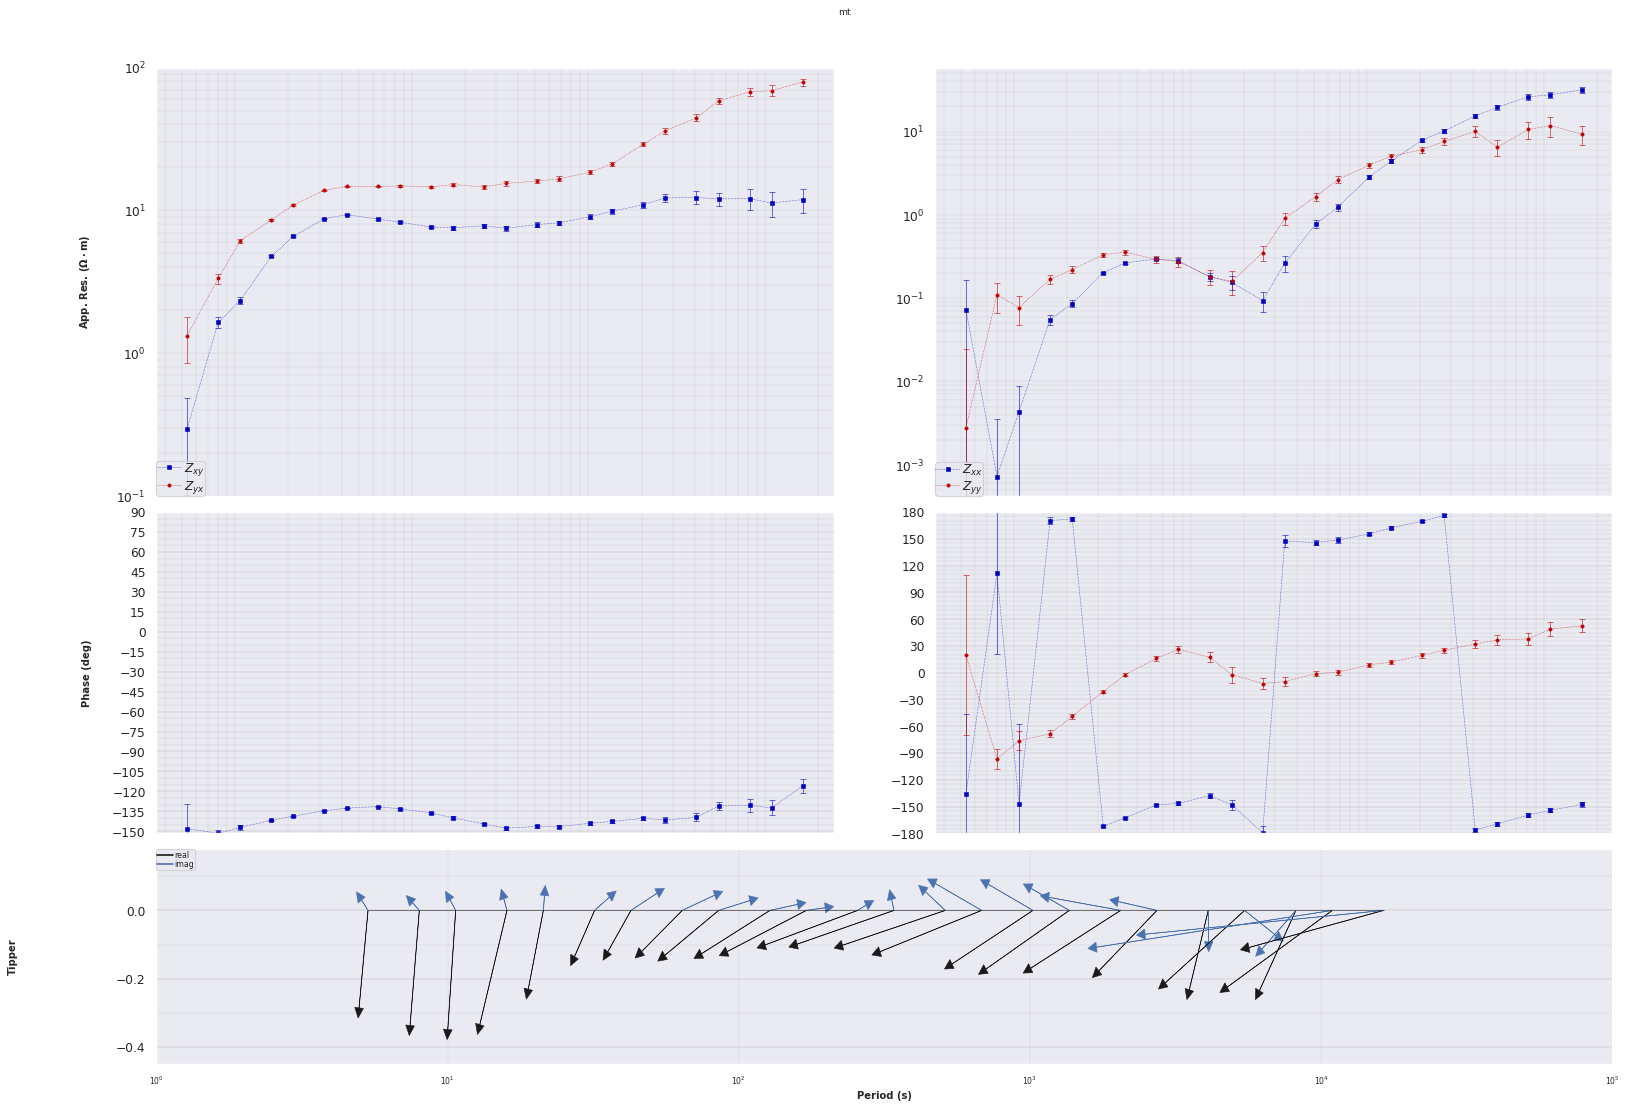

Saved figure to: drive/My Drive/st_deliver/20-Z-1/20-Z-1_edi_plot.pdf


<Figure size 2160x288 with 0 Axes>

In [0]:
plt.figure(figsize=(20, 15), dpi= 80)
mt_obj = mt.MT('/content/mt_birrp_out/20-Z-1/nfft_65536/mt.j')
pt_obj = mt_obj.plot_mt_response(plot_num= 2, # 1 = yx and xy; 2 = all 4 components # 3 = off diagonal + determinant
                                 plot_tipper ='yri',
                                 plot_pt ='n'  # plot phase tensor
                                 )
pt_obj.save_plot(DRIVE_OUT_PATH + '/{}_edi_plot.pdf'.format(STATION_NAME), file_format='pdf')

## Deliver

In [0]:
# pt_obj.save_plot(DRIVE_OUT_PATH + '/{}_edi_plot.pdf'.format(STATION_NAME), file_format='pdf')

In [0]:
# !zip -r outBIRRP mt.* 

In [0]:
# !mv './{STATION_NAME}.edi' './drive/My Drive/st_deliver/{STATION_NAME}/{STATION_NAME}.edi'
# !mv './mt.j' './drive/My Drive/st_deliver/{STATION_NAME}/mt.j
# !mv './{STATION_NAME}_birrp.script' './drive/My Drive/st_deliver/{STATION_NAME}/{STATION_NAME}_birrp.script'

In [0]:
# !rm -r mt*   #  {STATION_NAME}*
# !rm -r '/content/7-AV-1'   #  {STATION_NAME}*

In [0]:
!mv './mt_birrp_out/{STATION_NAME}' './drive/My Drive/st_deliver/range_fft/{STATION_NAME}'